In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import scipy.stats as stats

from pykrige.rk import Krige
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from math import sqrt

In [2]:
# Load Data
data = 'RF_residual_RFOK.csv'
df = pd.read_csv(data)
lon = np.array(df['LONG_X'])
lat = np.array(df['LAT_Y'])
coor = np.column_stack((lat, lon))
y = np.array(df['RF_residual'])

In [3]:
# Visualization function
def format_ax(ax, title, xlabel, ylabel, title_fontsize=14, label_fontsize=12):
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(axis='x', rotation=45)

In [4]:
# Scoring functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
scoring = {'RMSE': rmse_scorer, 'R2': r2_scorer}

In [5]:
# Parameter grid
weights_list = list(np.round(np.arange(0.1, 1.1, 0.1), 1)) + ['False']

param_dict = {
    "method": ["ordinary"],
    "variogram_model": ["gaussian", "spherical", "exponential"],
    "nlags": list(range(2, 22, 2)),
    "weight": weights_list,
    "coordinates_type": ["euclidean", "geographic"],
    "n_closest_points": list(range(1, 21, 1))
}

In [6]:
# Set up grid search
estimator = GridSearchCV(
    Krige(),
    param_dict,
    scoring=scoring,
    n_jobs=-1,
    verbose=True,
    return_train_score=True,
    refit='RMSE'
)

In [7]:
# Fit model
estimator.fit(X=coor, y=y)

Fitting 5 folds for each of 13200 candidates, totalling 66000 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan ... -52.95971311 -52.95971311
 -52.95971311]
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [            nan             nan             nan ... -1.26993831e-11
 -1.26993831e-11 -1.26993831e-11]
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.99507887 -0.99507887
 -0.99507887]
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan nan nan ...  1.  1.  1.]
  warnings.warn(


GridSearchCV(estimator=Krige(), n_jobs=-1,
             param_grid={'coordinates_type': ['euclidean', 'geographic'],
                         'method': ['ordinary'],
                         'n_closest_points': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'nlags': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'variogram_model': ['gaussian', 'spherical',
                                             'exponential'],
                         'weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    1.0, 'False']},
             refit='RMSE', return_train_score=True,
             scoring={'R2': make_scorer(r2_score),
                      'RMSE': make_scorer(rmse, greater_is_better=False)},
             verbose=True)

In [8]:
# Get the best parameters and the corresponding score for RMSE and R2
best_params = estimator.best_params_
best_rmse = abs(estimator.cv_results_['mean_test_RMSE'][estimator.best_index_])
best_r2 = estimator.cv_results_['mean_test_R2'][estimator.best_index_]

In [9]:
best_params, best_rmse, best_r2

({'coordinates_type': 'geographic',
  'method': 'ordinary',
  'n_closest_points': 18,
  'nlags': 2,
  'variogram_model': 'spherical',
  'weight': 0.1},
 52.20696829231897,
 -0.9334620960754447)

In [10]:
# Define a grid
lon_linspace = np.linspace(min(lon), max(lon), 191)
lat_linspace = np.linspace(min(lat), max(lat), 139)
grid_lon, grid_lat = np.meshgrid(lon_linspace, lat_linspace)
lon_linspace.shape, lat_linspace.shape, grid_lon.shape, grid_lat.shape

((191,), (139,), (139, 191), (139, 191))

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 747.1089612808886
Full Sill: 3692.0617704420624
Range: 0.000615040930194722
Nugget: 2944.9528091611737 



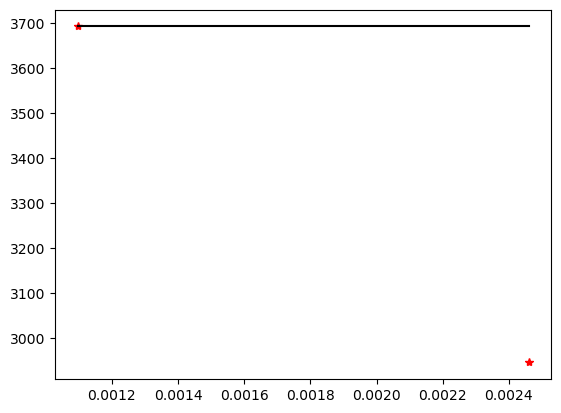

Calculating statistics on variogram model fit...
Q1 = 0.05248887161314701
Q2 = 0.962487432397307
cR = 3873.7234749816225 

Executing Ordinary Kriging...



In [11]:
if hasattr(estimator, 'best_params_'):
    # Retrieve the best variogram model and other parameters
    best_params = estimator.best_params_
    best_variogram_model = best_params['variogram_model']
    best_nlags = best_params.get('nlags', None)
    best_weight = best_params.get('weight', False)
    best_n_closest_points = best_params.get('n_closest_points')
    best_coordinates_type = best_params['coordinates_type']

    
    # Initialize the Ordinary Kriging model with the best parameters
    OK = OrdinaryKriging(
        lon, lat, y,
        variogram_model=best_variogram_model,
        nlags=best_nlags,
        weight=best_weight,
        verbose=True,
        enable_plotting=True,
        enable_statistics=True,
        coordinates_type=best_coordinates_type
    )
    
    # Perform the kriging
    z, ss = OK.execute('grid', lon_linspace, lat_linspace)

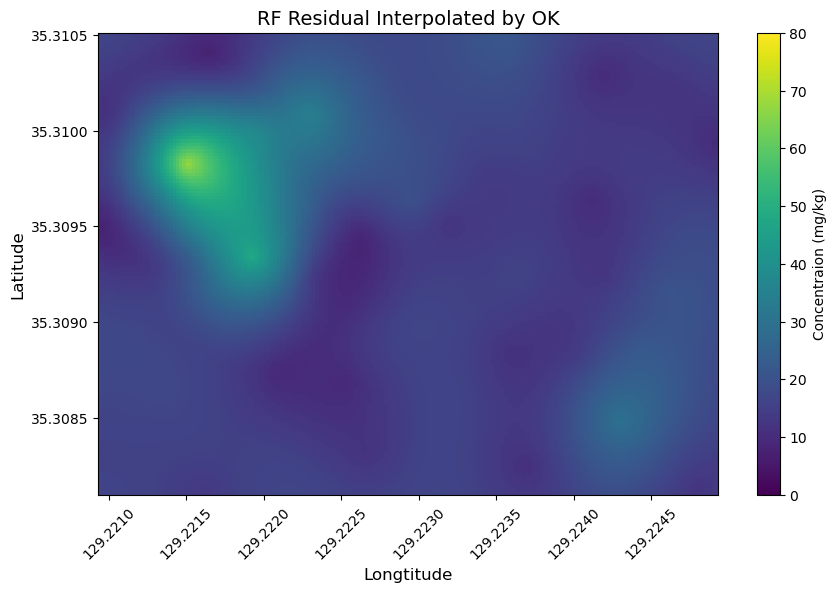

In [12]:
# Plot the kriged grid values
fig, ax = plt.subplots(figsize=(10, 6))
img = ax.imshow(z, origin='lower', aspect='auto', extent=[min(lon), max(lon), min(lat), max(lat)], vmin=0, vmax=80)
fig.colorbar(img, ax=ax, label='Concentraion (mg/kg)')
format_ax(ax, 'RF Residual Interpolated by OK', 'Longtitude', 'Latitude')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
plt.show()

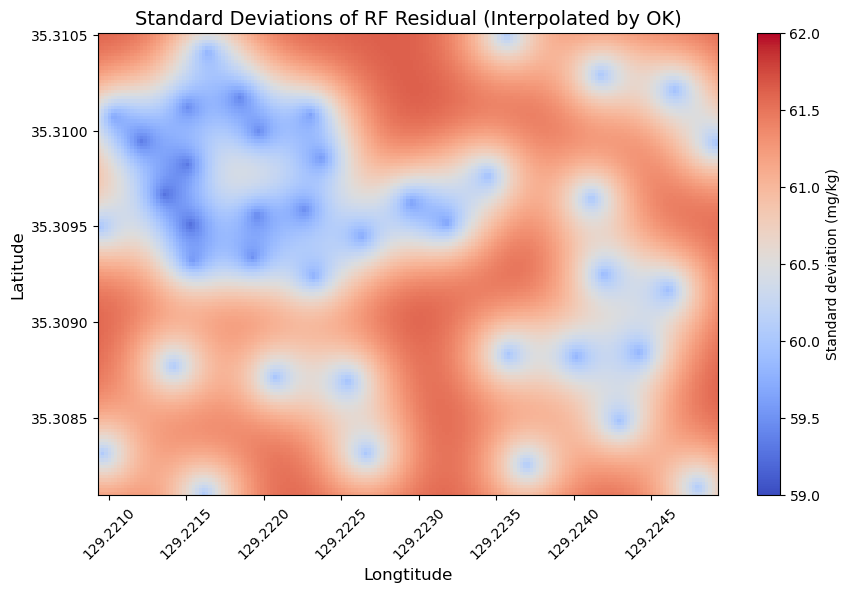

In [13]:
# Plot the kriging standard deviation
std = np.sqrt(ss)
fig, ax = plt.subplots(figsize=(10, 6))
img = ax.imshow(std, cmap='coolwarm',origin='lower', aspect='auto', extent=[min(lon), max(lon), min(lat), max(lat)], vmin=59, vmax=62)
fig.colorbar(img, ax=ax, label='Standard deviation (mg/kg)')
format_ax(ax, 'Standard Deviations of RF Residual (Interpolated by OK)', 'Longtitude', 'Latitude')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
plt.show()

In [14]:
z.data.shape

(139, 191)

In [15]:
# Flip the grid data vertically to match ArcGIS format
RF_residual_OK_pred_grid_flipped = np.flipud(z.data)

# Parameters - update these with the correct values for your data
cellsize = 2
xllcorner = 220084.70863526
yllcorner = 301293.62345657
nodata_value = -9999.00  

# Open a new text file for writing
output_file = 'RF_residual_OK_prediction_ascii.asc'
with open(output_file, 'w') as file:
    # Write the header
    file.write(f"ncols         {RF_residual_OK_pred_grid_flipped.shape[1]}\n")
    file.write(f"nrows         {RF_residual_OK_pred_grid_flipped.shape[0]}\n")
    file.write(f"xllcorner     {xllcorner}\n")
    file.write(f"yllcorner     {yllcorner}\n")
    file.write(f"cellsize      {cellsize}\n")
    file.write(f"NODATA_value  {nodata_value}\n")

    # Write the grid data
    for row in RF_residual_OK_pred_grid_flipped:
        file.write(' '.join(map(str, row)) + '\n')

print(f"Data exported to {output_file}")

Data exported to RF_residual_OK_prediction_ascii.asc


# RF+RF_residual_OK = RFOK

In [16]:
RF_pred = 'RF_prediction_ascii.asc'
RF_resi = 'RF_residual_OK_prediction_ascii.asc'

In [17]:
# Reading the content of the first file
with open(RF_pred, 'r') as file:
    RF_pred_content = file.readlines()

# Reading the content of the second file
with open(RF_resi, 'r') as file:
    RF_resi_content = file.readlines()

In [18]:
def parse_ascii_grid_correctly(file_content):
    """ Parses the content of an ASCII grid file into metadata and data values, correctly identifying metadata lines. """
    metadata = {}
    data_lines = []
    metadata_keys = {'ncols', 'nrows', 'xllcorner', 'yllcorner', 'cellsize', 'NODATA_value'}

    # Parsing the file line by line
    for line in file_content:
        parts = line.split()
        if parts[0] in metadata_keys:
            # Metadata line
            key = parts[0]
            value = ' '.join(parts[1:])
            metadata[key] = float(value) if '.' in value else int(value)
        else:
            # Data line
            data_lines.append(line)
    
    # Converting data part to numpy array
    data_values = np.array([list(map(float, line.split())) for line in data_lines])

    return metadata, data_values

# Re-parsing both files with the correct function
RF_pred_metadata, RF_pred_data = parse_ascii_grid_correctly(RF_pred_content)
RF_resi_metadata, RF_resi_data = parse_ascii_grid_correctly(RF_resi_content)

# Checking if the metadata is identical
metadata_identical = RF_pred_metadata == RF_resi_metadata

# Element-wise addition of the data values if metadata is identical
if metadata_identical:
    combined_data = RF_pred_data + RF_resi_data
else:
    combined_data = None

metadata_identical, combined_data.shape if combined_data is not None else "Metadata not identical"


(True, (139, 191))

In [19]:
combined_data

array([[320.90858663, 343.70675033, 351.98428127, ..., 106.83383573,
        106.8797559 , 106.92824484],
       [264.80992902, 323.86622292, 265.9390671 , ..., 116.63195942,
        120.85136403, 130.37982075],
       [195.46889628, 271.47032566, 294.4354188 , ..., 120.95150567,
        121.95407706, 133.69636461],
       ...,
       [ 70.25897234,  55.66187309,  52.0384878 , ...,  81.47683596,
         83.63985809,  72.85497822],
       [ 70.33781255,  55.34247928,  53.75817692, ...,  80.58556334,
         79.78757267,  72.86387667],
       [ 74.52404135,  74.48390487,  74.44142204, ...,  73.02918802,
         74.80966467,  73.45457419]])

In [20]:
# 상하반전
RFOK = np.flipud(combined_data)

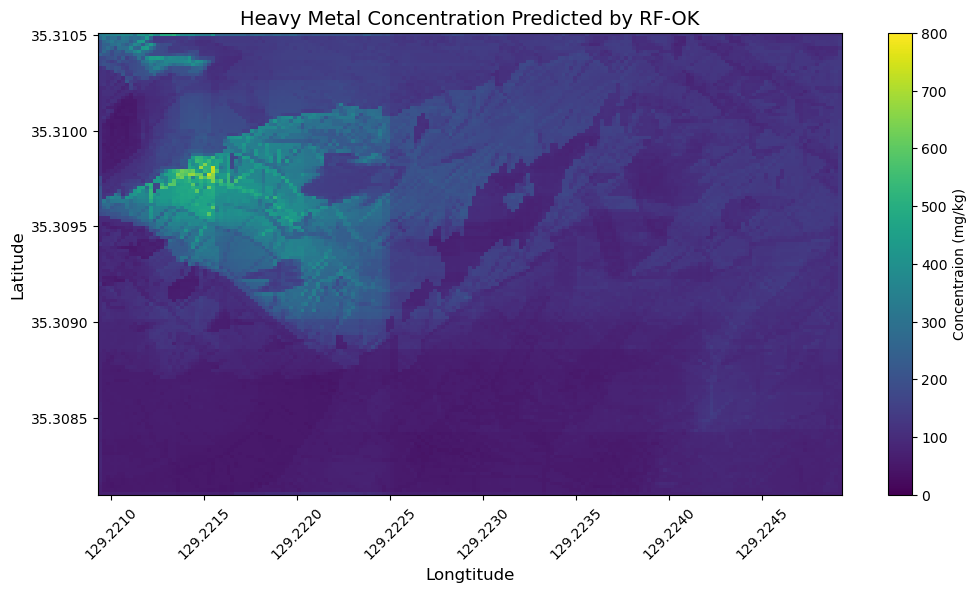

In [21]:
# Plot the kriged grid values
fig, ax = plt.subplots(figsize=(12, 6))
img = ax.imshow(RFOK, origin='lower', aspect='auto', extent=[min(lon), max(lon), min(lat), max(lat)], vmin=0, vmax=800)
fig.colorbar(img, ax=ax, label='Concentraion (mg/kg)')
format_ax(ax, 'Heavy Metal Concentration Predicted by RF-OK', 'Longtitude', 'Latitude')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
plt.show()

In [22]:
# Parameters - update these with the correct values for your data
cellsize = 2
xllcorner = 220084.70863526
yllcorner = 301293.62345657
nodata_value = -9999.00  

# Open a new text file for writing
output_file = 'RFOK_prediction_ascii.asc'
with open(output_file, 'w') as file:
    # Write the header
    file.write(f"ncols         {combined_data.shape[1]}\n")
    file.write(f"nrows         {combined_data.shape[0]}\n")
    file.write(f"xllcorner     {xllcorner}\n")
    file.write(f"yllcorner     {yllcorner}\n")
    file.write(f"cellsize      {cellsize}\n")
    file.write(f"NODATA_value  {nodata_value}\n")

    # Write the grid data
    for row in combined_data:
        file.write(' '.join(map(str, row)) + '\n')

print(f"Data exported to {output_file}")

Data exported to RFOK_prediction_ascii.asc
